In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs


#### K-Nearest Neighbors Algorithm
The K-Nearest Neighbors (KNN) algorithm is a versatile algorithm that can be used for both regression and classification tasks. In this explanation, I will focus on using KNN for a classification task.

What is the K-Nearest Neighbors Algorithm?

- The K-Nearest Neighbors (KNN) algorithm works on the principle that "similar points are in close proximity". The steps involved are quite simple: 
    - For a  given query point, we identify its K nearest neighbors, i.e., the closest points to it.

    - For a **classification** task, we count the number of points belonging to each class among the K nearest neighbors. For example, if we have 2 classes (A and B) and K = 5, and we find that 2 points belong to class A and 3 points belong to class B, we classify the new point as part of class B.

    - For a **regression** task, we take the mean of the values of all the K nearest points to predict the value for the new point.

let's implement a function to do just that.


In [2]:
#Createing synthetic dataset with 2 features and 2 classes
X_values, y_values = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42) #make_blobs is a function is in sklearn, which generates synthetic data in form of "blobs"
#Converting the class labels to 'A' and 'B'
y_values = np.where(y_values == 0, 'A', 'B')

print(X_values)
print(y_values)

[[-2.98837186  8.82862715]
 [ 5.72293008  3.02697174]
 [-3.05358035  9.12520872]
 [ 5.461939    3.86996267]
 [ 4.86733877  3.28031244]
 [-2.14780202 10.55232269]
 [ 4.91656964  2.80035293]
 [ 3.08921541  2.04173266]
 [-2.90130578  7.55077118]
 [-3.34841515  8.70507375]
 [-2.44166942  7.58953794]
 [ 3.40292813  0.65271307]
 [-2.97867201  9.55684617]
 [-3.83738367  9.21114736]
 [ 3.95985411  2.20542338]
 [ 3.85662554  1.65110817]
 [ 4.70010905  4.4364118 ]
 [ 3.56898634  2.4556421 ]
 [ 4.69808755  0.83019939]
 [-2.41743685  7.02671721]
 [ 4.85397258  0.72743091]
 [ 4.44751787  2.27471703]
 [ 5.43091078  1.06378223]
 [ 5.60325497  2.38595061]
 [ 4.89976163  2.75499256]
 [-0.92998481  9.78172086]
 [ 4.56277713  2.31432166]
 [-1.6966718  10.37052616]
 [ 5.1618204   2.27015436]
 [ 4.375222    4.69333885]
 [-2.743351    8.78014917]
 [-3.98771961  8.29444192]
 [-3.6601912   9.38998415]
 [-1.04354885  8.78850983]
 [-2.16557933  7.25124597]
 [ 5.22673593  4.16362531]
 [ 4.81305976  2.35848706]
 

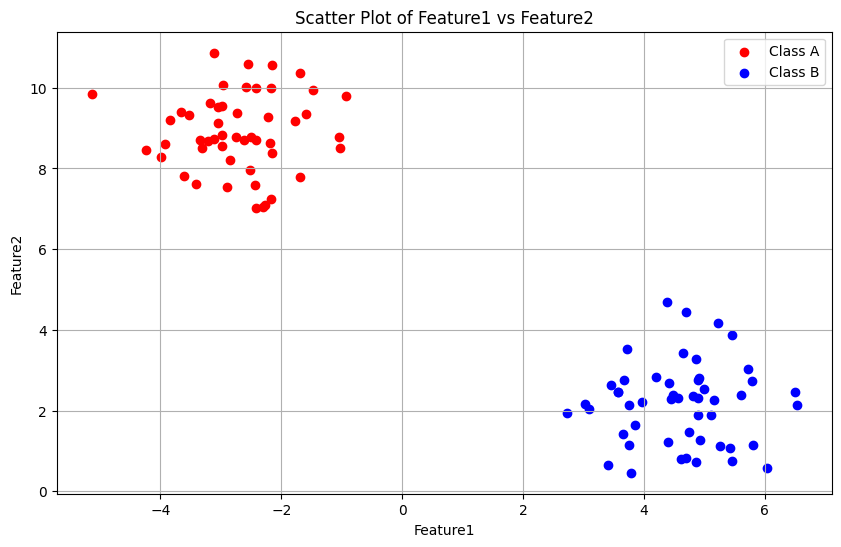

In [3]:
#let's plt this data.

plt.figure(figsize=(10, 6))
plt.scatter(X_values[y_values == 'A', 0], X_values[y_values == 'A', 1], color='red', label='Class A')
plt.scatter(X_values[y_values == 'B', 0], X_values[y_values == 'B', 1], color='blue', label='Class B')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Scatter Plot of Feature1 vs Feature2')
plt.legend()
plt.grid(True)
plt.show()

Now, in this data we want our model to predict Class A or red if our point is closed to this class (or B if it is close to b), for this first we need to create a function that calculates the distance of each point from our test point.

In [4]:
#defining the distance function

#Used for continuous data
def eculidian_distance(x,query):
    """
    This function takes in the traning values, the query and calculates the distance between this query and every point in traning values.

    Args:
        x (ndarray) : traning point (x,y)
        query (ndarray) : point to predict class for. (x,y)

    Returns:
        distance (float) : distance of point "query" from "x"
    """
    euclid_dist = 0
    for i in range(len(x)):
        euclid_dist += (x[i] - query[i])**2
    
    return (euclid_dist)**(0.5)

#Used for Categorical data
def hamming_distance(x, query):
    """
    Calculate the Hamming distance between two binary arrays x and query.

    Args:
        x (ndarray): Binary array (e.g., [0, 1, 0, 1])
        query (ndarray): Binary array to compare with x

    Returns:
        distance (int): Hamming distance between x and query
    """
    distance = 0

    for i in range(len(x)):
        if x[i] != query[i]:
            distance += 1

    return distance


# Defining the choice function for regression
def in_regression(selected_y):
    """
    Calculate the mean of selected_y for regression.

    Args:
        selected_y (ndarray): Array of selected y-values (target values).

    Returns:
        float: Mean of the selected y-values.
    """
    return np.mean(selected_y)

# Defining the choice function for classification
def in_classification(selected_y):
    """
    Calculate the mode of selected_y for classification.

    Args:
        selected_y (ndarray): Array of selected y-values (target values).

    Returns:
        scalar: Mode of the selected y-values.
    """
    values, counts = np.unique(selected_y, return_counts=True)
    index = np.argmax(counts)
    return values[index]

#### I have created 2 Choice functions, as major difference between the KNN-classification and regression is:
- In Classification: The final prediction is determined by identifying the most frequently occurring class among the nearest neighbors.
- In Regression: The final prediction is obtained by calculating the mean value of the target variable across the nearest neighbors.

In [5]:
def run_knn(X,y,query,k,distance_function,choice_funcition):
    """
    This function runs the KNN algorithm to predict the class of a query point.

    Args:
        X (ndarray): Input points (training data).
        y (ndarray): Target classes (training labels).
        query (ndarray): Point to make prediction on.
        k (int): Number of nearest neighbors to consider.
        distance_function (function): Function to calculate the distance between points.
        choice_function (function): Function to determine the final prediction.

    Returns:
        prediction (scalar): Prediction made by the model.
    """

    k_nearest_neighbour_values = []
    distances_indices = []

    for i in range(X.shape[0]):
        distances_indices.append([distance_function(X[i],query),i])
    
    distances_indices = sorted(distances_indices)

    for i in range(k):
        k_nearest_neighbour_values.append(y[distances_indices[i][1]])

    return choice_funcition(k_nearest_neighbour_values)
    

Prediction for [0, 8] : A


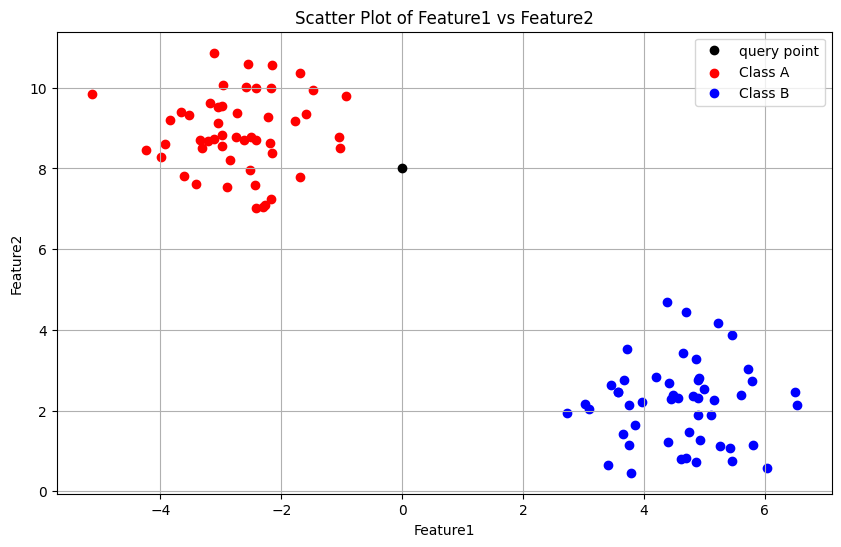

In [6]:
#Now, let's test this Algo, let's give it a point (0,8). by the graph the algorithm should classify it as A.
query = [0,8]
k = 5
prediction = run_knn(X_values,y_values,query,k,eculidian_distance,in_classification)

print(f"Prediction for {query} : {prediction}")

#let's plot this on the data
plt.figure(figsize=(10, 6))
plt.plot(query[0],query[1],'ko',label = "query point")
plt.scatter(X_values[y_values == 'A', 0], X_values[y_values == 'A', 1], color='red', label='Class A')
plt.scatter(X_values[y_values == 'B', 0], X_values[y_values == 'B', 1], color='blue', label='Class B')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Scatter Plot of Feature1 vs Feature2')
plt.legend()
plt.grid(True)
plt.show()

#### Now, the algorithm was fairly easy to implement and understand, but there are points that we still need to address.

- How to choose the value of **K**:

    In most cases, this depends on the type of task performed. For classification, we typically choose K to be odd, while for regression, any positive integer can be used. Selecting K is critical:
    - Choosing too high a K value can lead to overfitting.
    - Choosing too low a K value can result in underfitting.
    
    Therefore, it's common practice to run our algorithm with different values of K and use evaluation metrics to determine the optimal K value for our model's best performance.

- Type of distance we choose (e.g., **Euclidean**, **Hamming**, etc.):

    The choice of distance metric, such as Euclidean for continuous data or Hamming for categorical data, depends on the data's characteristics. Picking the right metric is crucial:
    - Euclidean distance suits continuous numerical data.
    - Hamming distance fits categorical or binary data.
    
    Like selecting K, the chosen distance metric significantly influences model performance. Experimenting with different metrics and using evaluation measures helps determine the most effective metric for enhancing model accuracy and reliability.
    
    In our case we choose Euclidean distance as our input features were continuous.

- Data needs to be prepared and structured properly, as this algorithm is sensitive to outliers. The presence of outliers can disrupt predictions         (additonally and missing values as well).

- Major Disadvantage of this Algo is with larger amount of data the Algo becomes slower.